In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

2024-01-29 15:56:09.940074: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 15:56:09.942672: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 15:56:09.977674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 15:56:09.977690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 15:56:09.978578: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.15.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


# Chapter 13 

## 13.1 Creating windows of data
### 13.1.1 Exploring how deep learning models are trained for time series forecasting

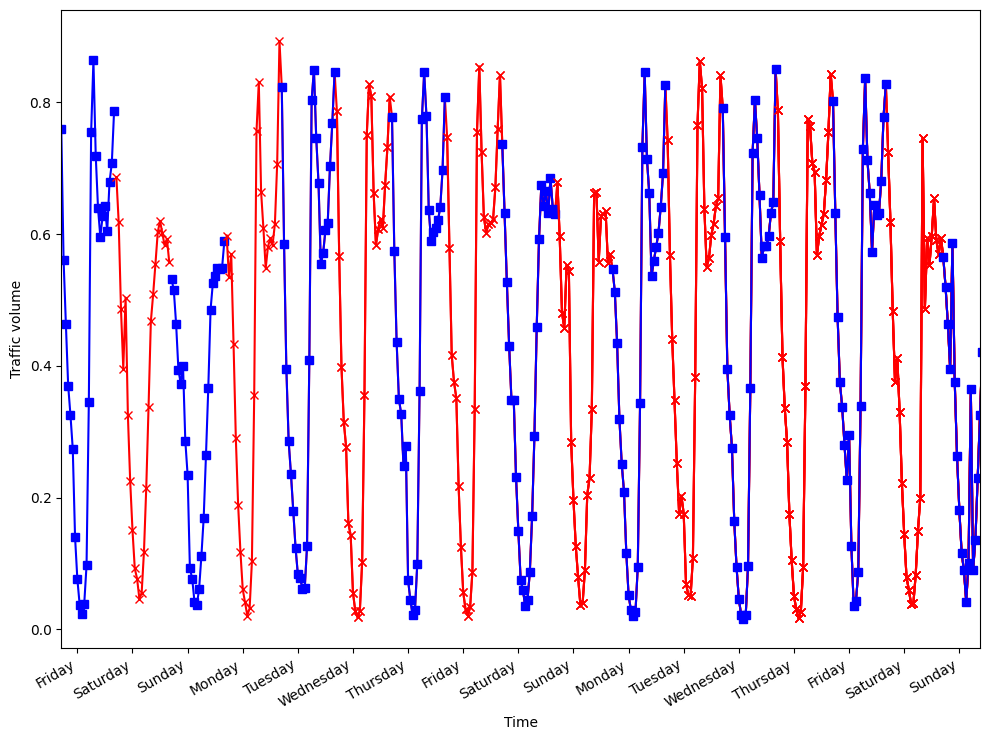

In [6]:
fig, ax = plt.subplots()

for n in range(0,17,2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='red', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH13_F01_peixeiro.png', dpi=300)

### 13.1.2 Implementing the `DataWindow` class 

In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## 13.2 Applying baseline models
### 13.2.1 Single-step baseline model

In [8]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [9]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [10]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['traffic_volume'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [11]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 [==============================] - 0s 1ms/step - loss: 0.0133 - mean_absolute_error: 0.0831


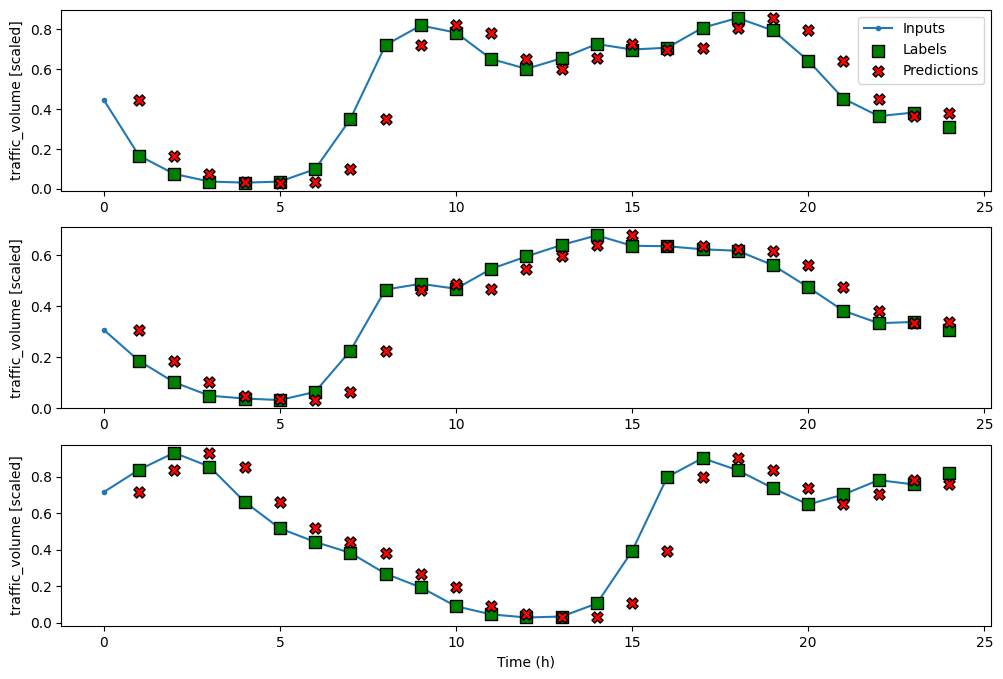

In [12]:
wide_window.plot(baseline_last)

plt.savefig('figures/CH13_F09_peixeiro.png', dpi=300)

In [13]:
print(performance['Baseline - Last'][1])

0.08128400146961212


### 13.2.2 Multi-step baseline models 

In [14]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

#### Predicting the last known value 

In [15]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [16]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 0s 828us/step - loss: 0.1874 - mean_absolute_error: 0.3520


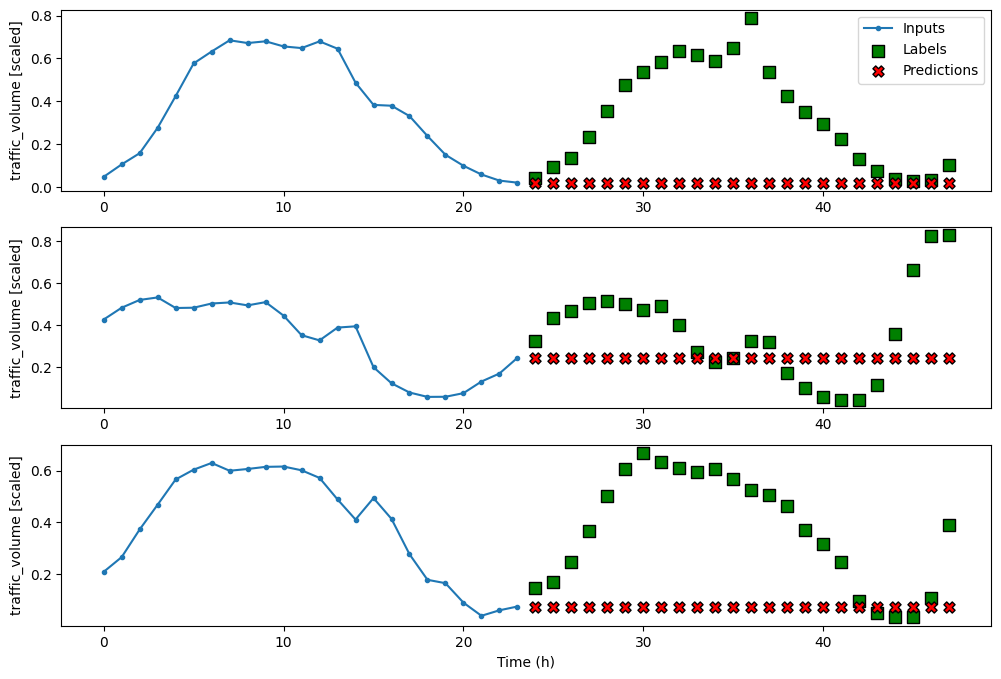

In [17]:
multi_window.plot(ms_baseline_last)

plt.savefig('figures/CH13_F10_peixeiro.png', dpi=300)

In [18]:
print(ms_performance['Baseline - Last'][1])

0.34706419706344604


#### Repeating the input sequence 

In [19]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [20]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 0s 798us/step - loss: 0.2125 - mean_absolute_error: 0.3533


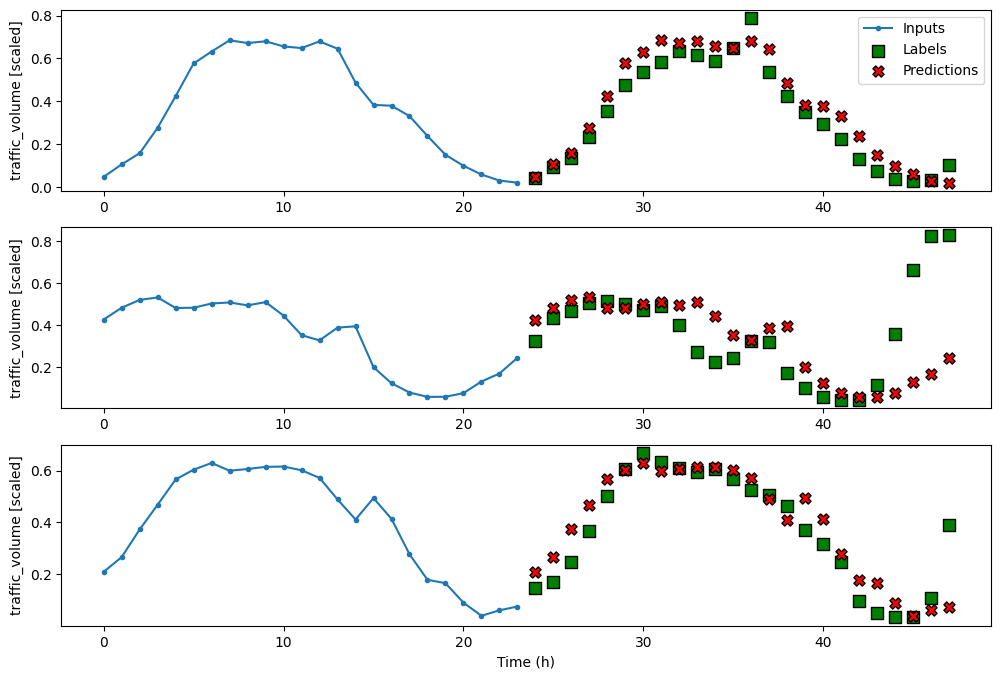

In [21]:
multi_window.plot(ms_baseline_repeat)

plt.savefig('figures/CH13_F11_peixeiro.png', dpi=300)

In [22]:
print(ms_performance['Baseline - Repeat'][1])

0.3439045250415802


### 13.2.3 Multi-output baseline model 

In [23]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [24]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [25]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

 51/109 [=============>................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0481 

109/109 [==============================] - 0s 875us/step - loss: 0.0069 - mean_absolute_error: 0.0482


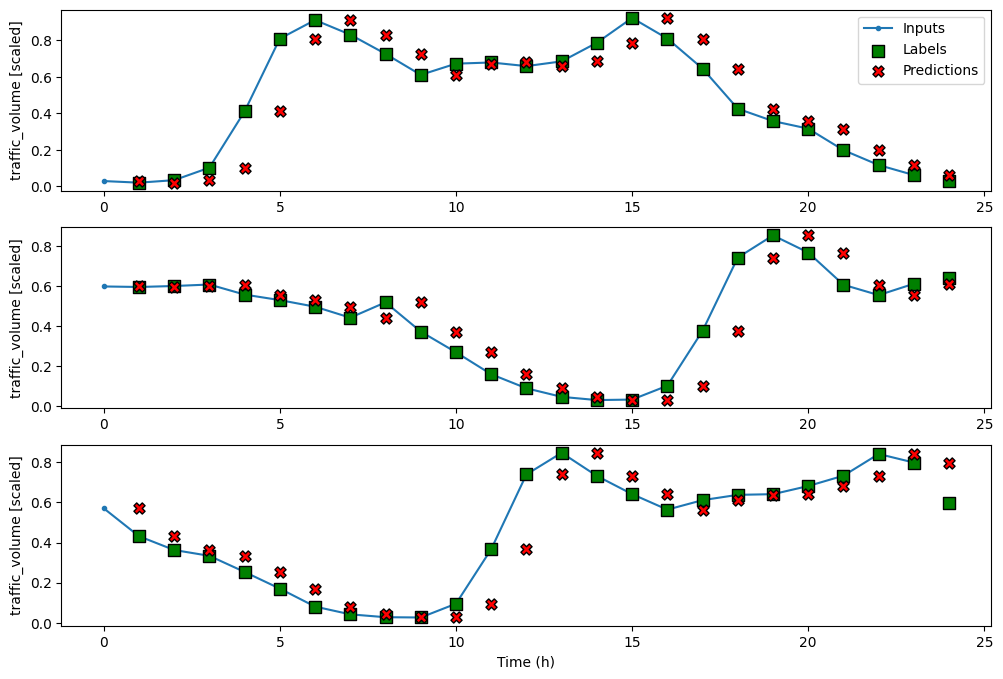

In [26]:
mo_wide_window.plot(mo_baseline_last)

plt.savefig('figures/CH13_F12_peixeiro.png', dpi=300)

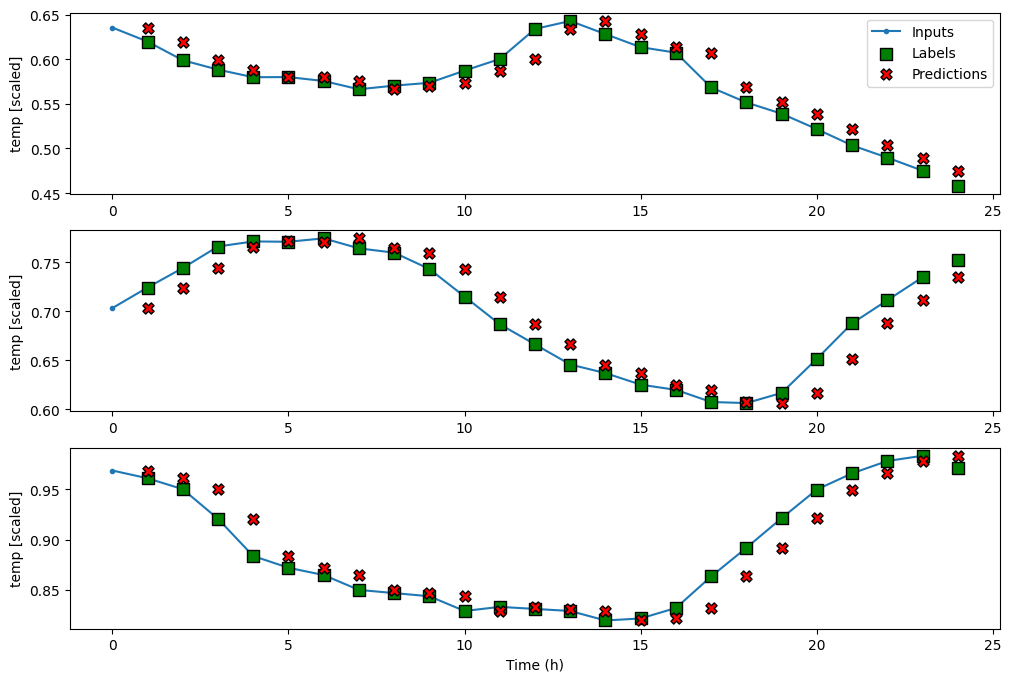

In [27]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

plt.savefig('figures/CH13_F13_peixeiro.png', dpi=300)

In [28]:
print(mo_performance['Baseline - Last'][1])

0.04710666462779045


# Chapter 14 

## 14.1 Implementing a linear model
### 14.1.1 Building a single-step linear model

In [29]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [30]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50


384/384 [==============================] - 1s 2ms/step - loss: 1.2608 - mean_absolute_error: 0.9490 - val_loss: 0.5653 - val_mean_absolute_error: 0.6452
Epoch 2/50
384/384 [==============================] - 1s 1ms/step - loss: 0.3565 - mean_absolute_error: 0.5252 - val_loss: 0.2593 - val_mean_absolute_error: 0.4556
Epoch 3/50
384/384 [==============================] - 1s 1ms/step - loss: 0.1911 - mean_absolute_error: 0.3885 - val_loss: 0.1500 - val_mean_absolute_error: 0.3418
Epoch 4/50
384/384 [==============================] - 1s 1ms/step - loss: 0.1078 - mean_absolute_error: 0.2864 - val_loss: 0.0838 - val_mean_absolute_error: 0.2493
Epoch 5/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0597 - mean_absolute_error: 0.2057 - val_loss: 0.0480 - val_mean_absolute_error: 0.1801
Epoch 6/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0355 - mean_absolute_error: 0.1507 - val_loss: 0.0311 - val_mean_absolute_error: 0.1400
Epoch 7/50
384/384 [=======

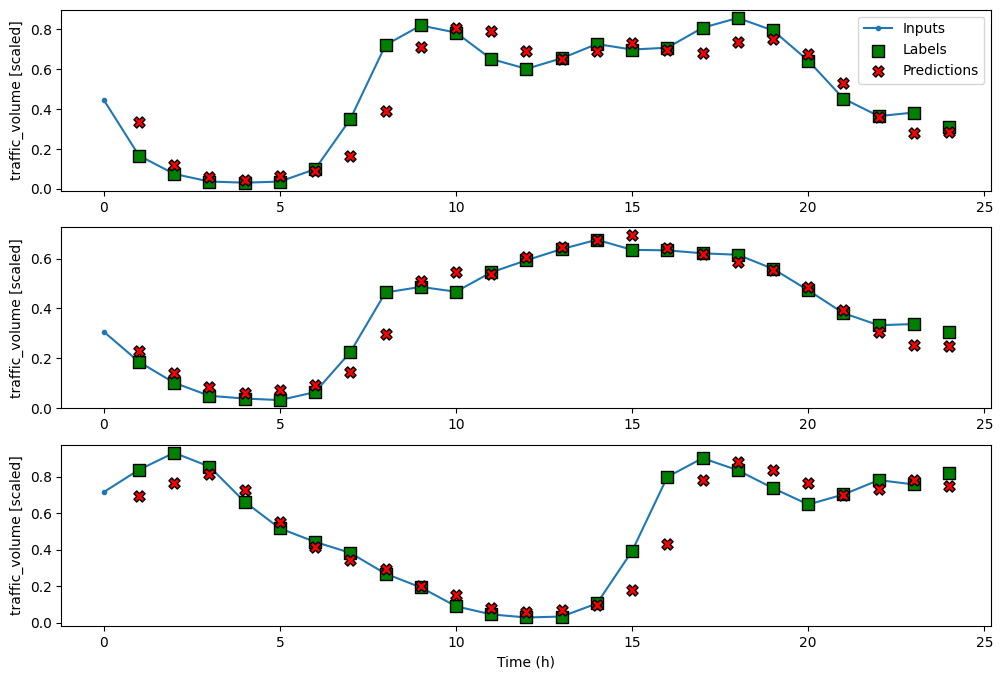

In [31]:
wide_window.plot(linear)

plt.savefig('figures/CH14_F02_peixeiro.png', dpi=300)

### 14.1.2 Building a mutli-step linear model 

In [32]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50


383/383 [==============================] - 1s 2ms/step - loss: 0.0917 - mean_absolute_error: 0.2517 - val_loss: 0.0452 - val_mean_absolute_error: 0.1792
Epoch 2/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0302 - mean_absolute_error: 0.1401 - val_loss: 0.0249 - val_mean_absolute_error: 0.1232
Epoch 3/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0200 - mean_absolute_error: 0.1067 - val_loss: 0.0207 - val_mean_absolute_error: 0.1068
Epoch 4/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0176 - mean_absolute_error: 0.0963 - val_loss: 0.0194 - val_mean_absolute_error: 0.1001
Epoch 5/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0168 - mean_absolute_error: 0.0914 - val_loss: 0.0187 - val_mean_absolute_error: 0.0957
Epoch 6/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0163 - mean_absolute_error: 0.0884 - val_loss: 0.0184 - val_mean_absolute_error: 0.0928
Epoch 7/50
383/383 [=======

### 14.1.3 Implementing a multi-output linear model 

In [33]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.1435 - mean_absolute_error: 0.3003 - val_loss: 0.0902 - val_mean_absolute_error: 0.2381
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0591 - mean_absolute_error: 0.1886 - val_loss: 0.0419 - val_mean_absolute_error: 0.1611
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0277 - mean_absolute_error: 0.1283 - val_loss: 0.0211 - val_mean_absolute_error: 0.1146
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0148 - mean_absolute_error: 0.0936 - val_loss: 0.0122 - val_mean_absolute_error: 0.0867
Epoch 5/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0094 - mean_absolute_error: 0.0732 - val_loss: 0.0082 - val_mean_absolute_error: 0.0686
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0607 - val_loss: 0.0064 - val_mean_absolute_error: 0.0580
Epoch 7/50
384/3

## 14.2 Implementing a deep neural network
### 14.2.1 Implementing a deep neural network as a single-step model

In [34]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50


384/384 [==============================] - 1s 2ms/step - loss: 0.0149 - mean_absolute_error: 0.0751 - val_loss: 0.0037 - val_mean_absolute_error: 0.0459
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0035 - mean_absolute_error: 0.0435 - val_loss: 0.0027 - val_mean_absolute_error: 0.0392
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0030 - mean_absolute_error: 0.0394 - val_loss: 0.0022 - val_mean_absolute_error: 0.0347
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0027 - mean_absolute_error: 0.0375 - val_loss: 0.0024 - val_mean_absolute_error: 0.0373
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0026 - mean_absolute_error: 0.0367 - val_loss: 0.0021 - val_mean_absolute_error: 0.0333
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0025 - mean_absolute_error: 0.0360 - val_loss: 0.0021 - val_mean_absolute_error: 0.0345
Epoch 7/50
384/384 [=======

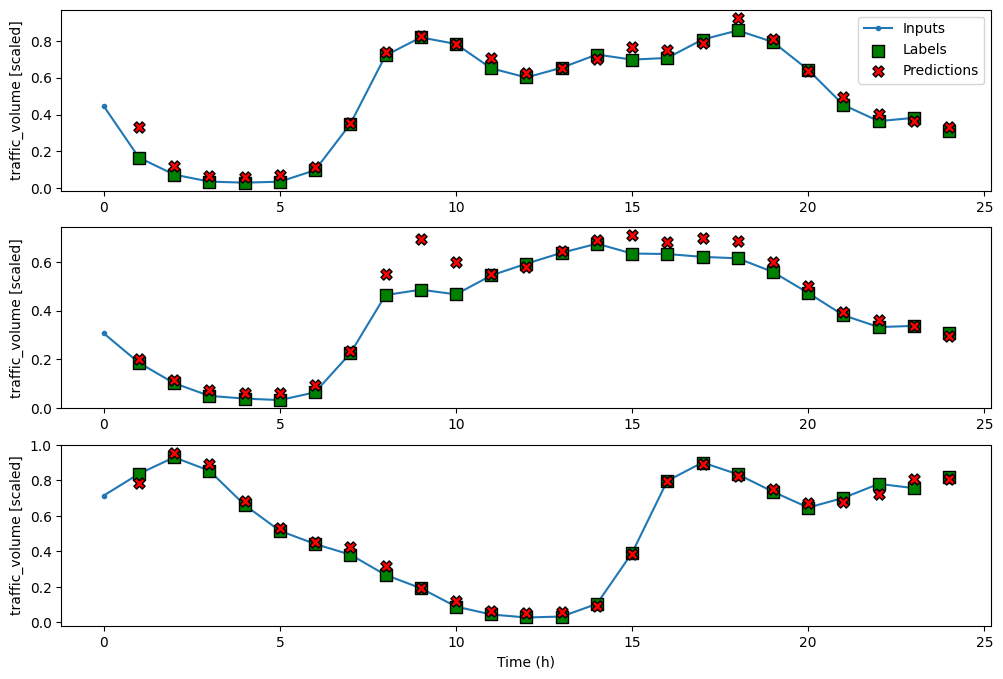

In [35]:
wide_window.plot(dense)

plt.savefig('figures/CH14_F06_peixeiro.png', dpi=300)

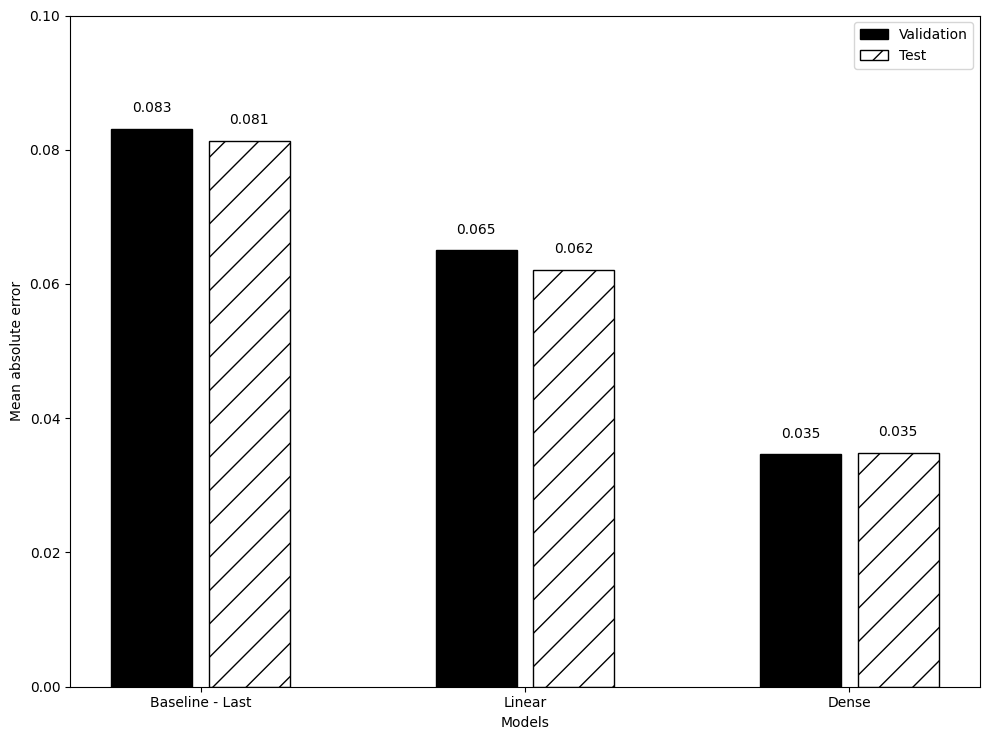

In [36]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH14_F07_peixeiro.png', dpi=300)

### 14.2.2 Implementing a deep neural network as a multi-step model 

In [37]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50


383/383 [==============================] - 2s 3ms/step - loss: 0.0319 - mean_absolute_error: 0.1157 - val_loss: 0.0152 - val_mean_absolute_error: 0.0807
Epoch 2/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0134 - mean_absolute_error: 0.0773 - val_loss: 0.0151 - val_mean_absolute_error: 0.0792
Epoch 3/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0130 - mean_absolute_error: 0.0759 - val_loss: 0.0146 - val_mean_absolute_error: 0.0832
Epoch 4/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0128 - mean_absolute_error: 0.0756 - val_loss: 0.0139 - val_mean_absolute_error: 0.0810
Epoch 5/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0127 - mean_absolute_error: 0.0749 - val_loss: 0.0142 - val_mean_absolute_error: 0.0756
Epoch 6/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0126 - mean_absolute_error: 0.0749 - val_loss: 0.0140 - val_mean_absolute_error: 0.0750
Epoch 7/50
383/383 [=======

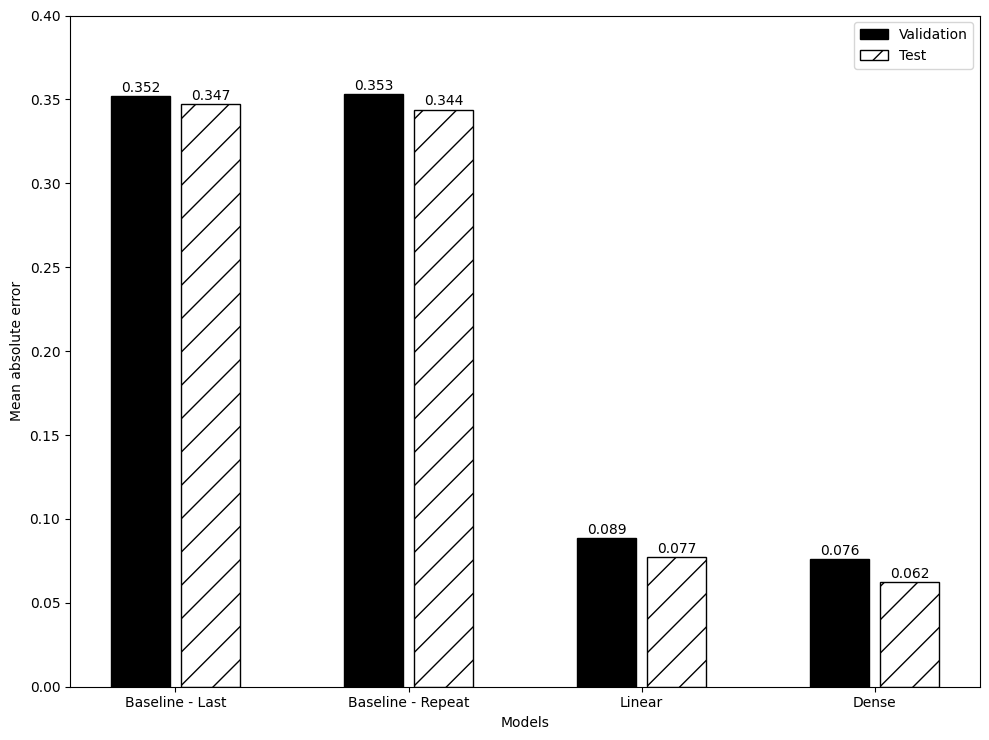

In [38]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH14_F08_peixeiro.png', dpi=300)

### 14.2.3 Implementing a deep neural network as a multi-output model 

In [39]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50


384/384 [==============================] - 1s 2ms/step - loss: 0.0146 - mean_absolute_error: 0.0663 - val_loss: 0.0024 - val_mean_absolute_error: 0.0314
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0024 - mean_absolute_error: 0.0309 - val_loss: 0.0017 - val_mean_absolute_error: 0.0271
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0275 - val_loss: 0.0013 - val_mean_absolute_error: 0.0230
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0260 - val_loss: 0.0015 - val_mean_absolute_error: 0.0256
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0255 - val_loss: 0.0012 - val_mean_absolute_error: 0.0222
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0252 - val_loss: 0.0012 - val_mean_absolute_error: 0.0216
Epoch 7/50
384/384 [=======

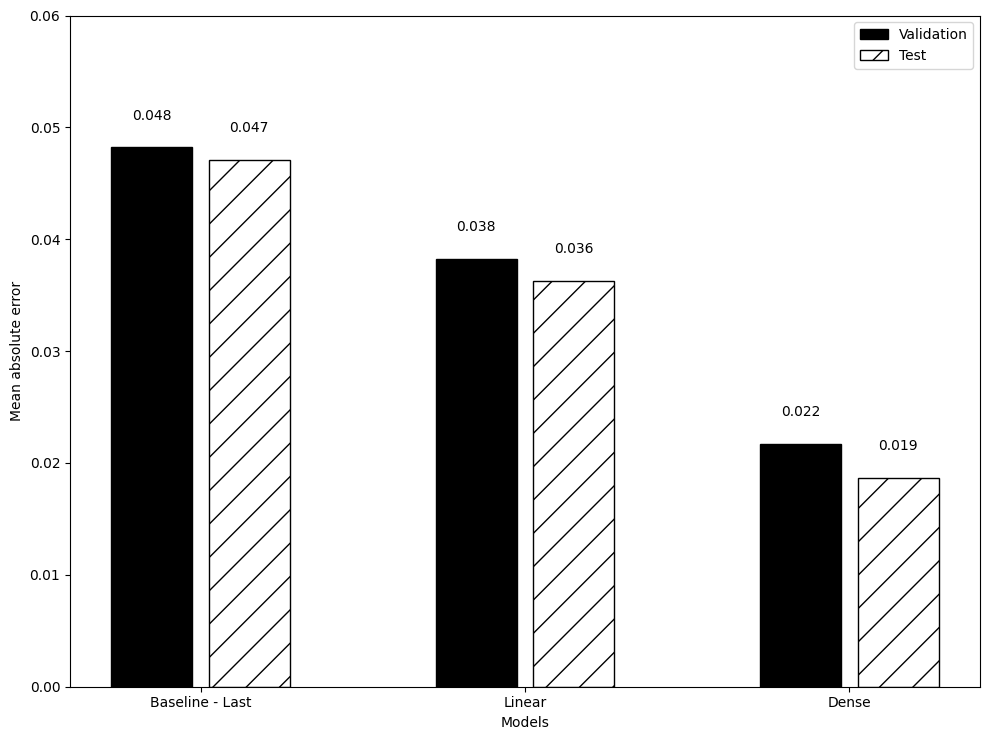

In [40]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH14_F09_peixeiro.png', dpi=300)